In [5]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import CountEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import catboost
import xgboost as xgb

## Research

In [8]:
X = pd.read_csv("../../proj_datasets/richter_prediction/train_values.csv")
Y = pd.read_csv("../../proj_datasets/richter_prediction/train_labels.csv")

In [71]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
1,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
2,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
3,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
4,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0


In [5]:
Y.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [6]:
print(f"Train values - {X.shape[0]}\nTrain Labels: {Y.shape[0]}")

Train values - 260601
Train Labels: 260601


In [9]:
X.drop("building_id", axis=1, inplace=True)
Y.drop("building_id", axis = 1, inplace=True)

In [54]:
df = pd.concat([X, Y], axis=1)

In [55]:
df.shape

(260601, 39)

In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-null 

In [10]:
X.isnull().sum().sum()

0

In [11]:
obj_cols = []
for col in X.columns:
    if X[col].dtype == "object":
        obj_cols.append(col)

In [12]:
for col in obj_cols:
    print(f"{col}: {X[col].unique()}")

land_surface_condition: ['t' 'o' 'n']
foundation_type: ['r' 'w' 'i' 'u' 'h']
roof_type: ['n' 'q' 'x']
ground_floor_type: ['f' 'x' 'v' 'z' 'm']
other_floor_type: ['q' 'x' 'j' 's']
position: ['t' 's' 'j' 'o']
plan_configuration: ['d' 'u' 's' 'q' 'm' 'c' 'a' 'n' 'f' 'o']
legal_ownership_status: ['v' 'a' 'r' 'w']


In [13]:
x_with_int_cols = X.drop(obj_cols, axis=1, inplace=False)

### Outlier Viz for numerical data using box plot

In [14]:
numerical_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage']

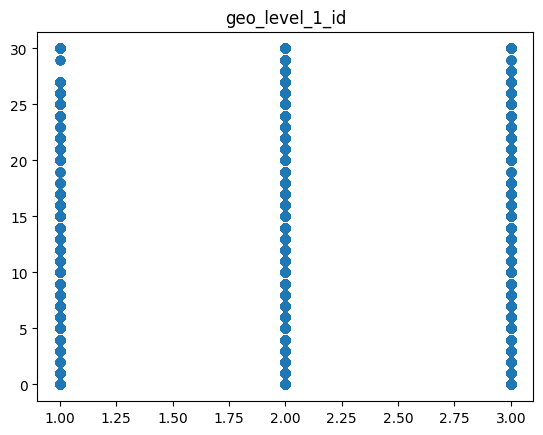

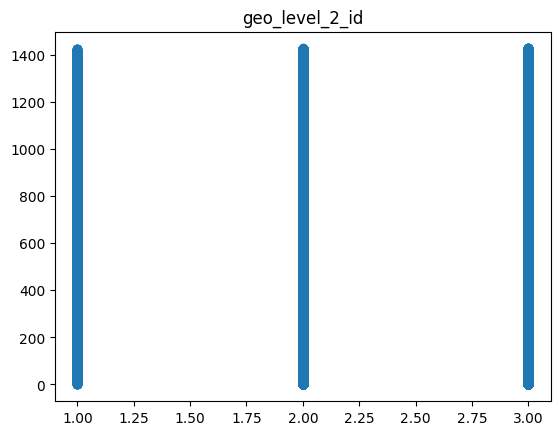

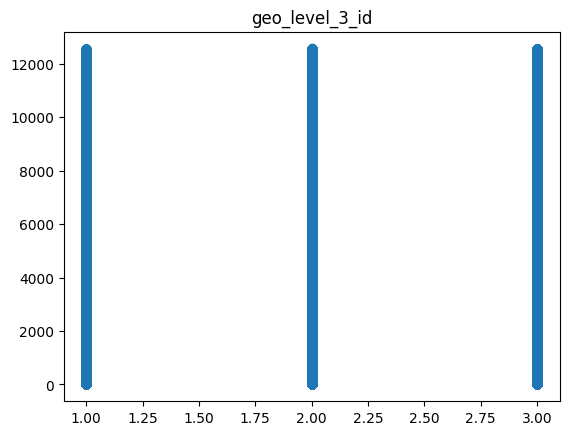

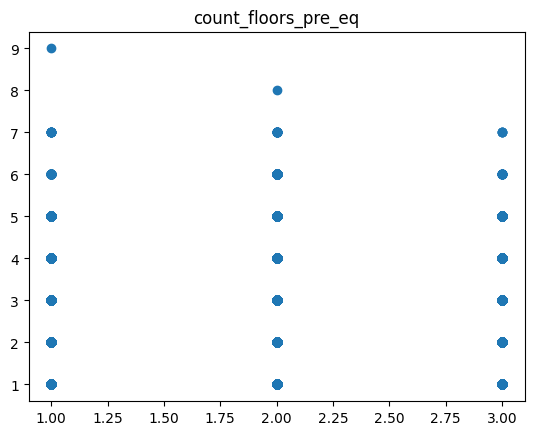

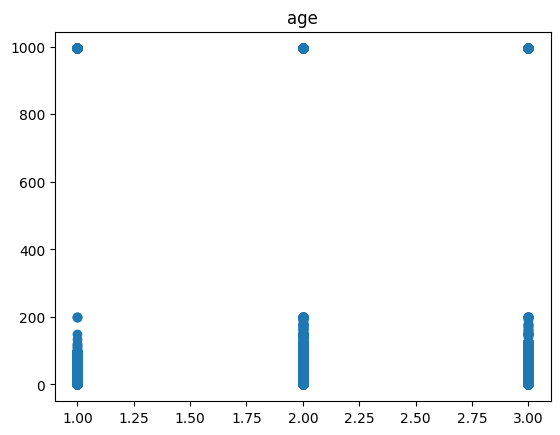

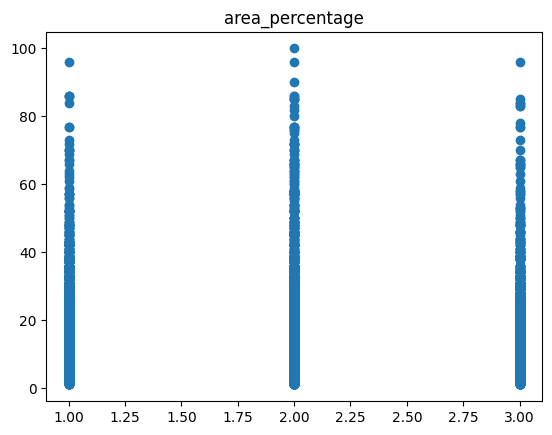

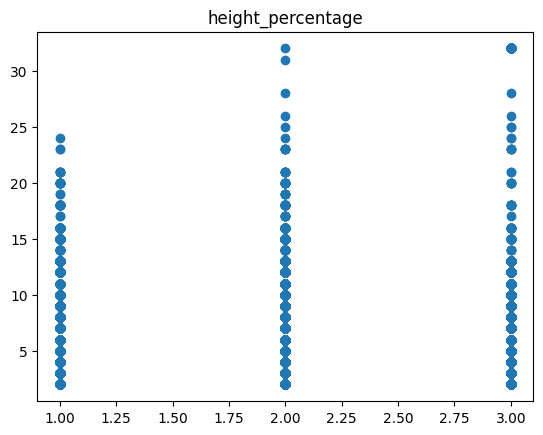

In [27]:
for col in numerical_cols:
    plt.title(col)
    plt.scatter(Y['damage_grade'], X[col])
    plt.show()

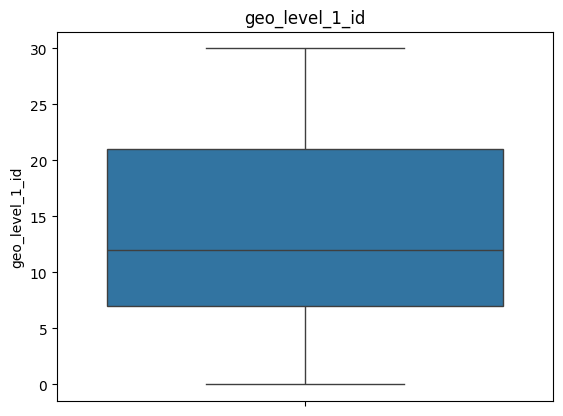

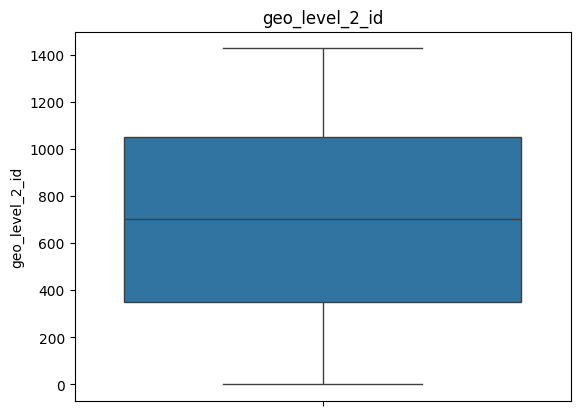

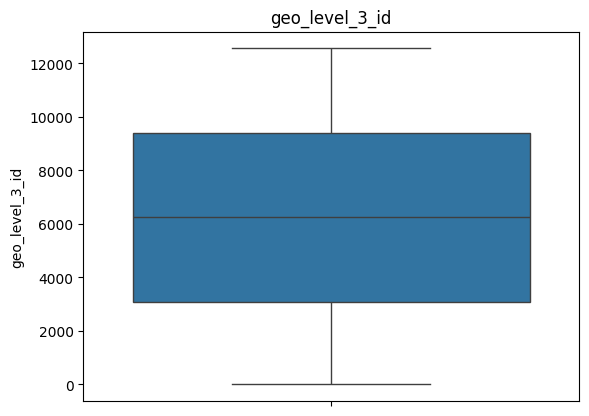

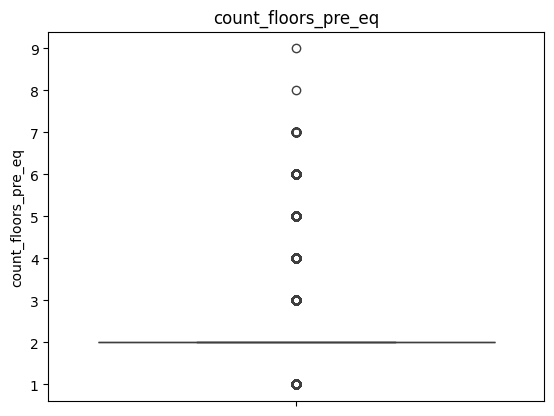

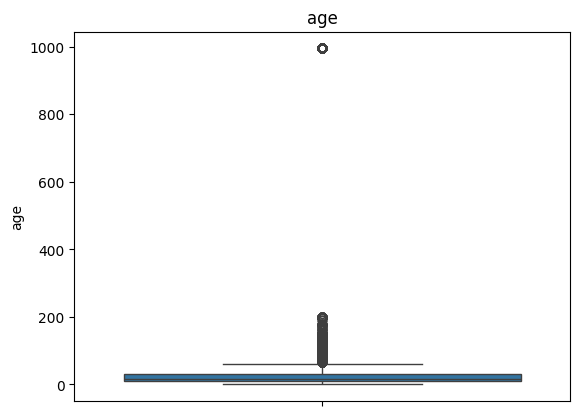

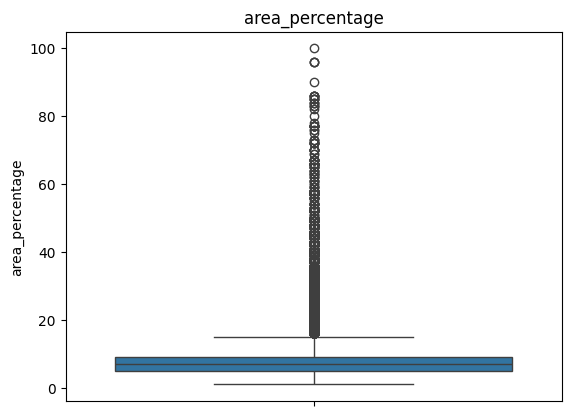

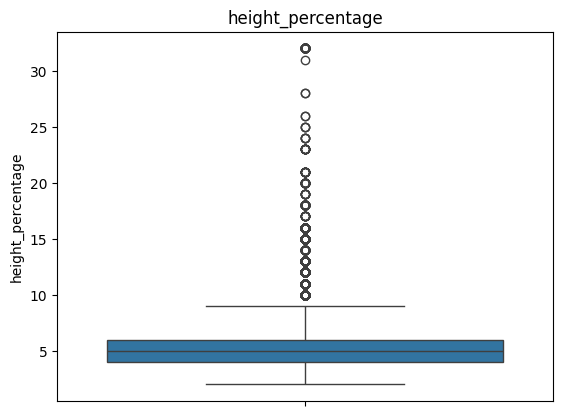

In [28]:
for col in numerical_cols:
    plt.title(col)
    sns.boxplot(X[col])
    plt.show()

In [46]:
# remove data with age = 1000
print(df[(df['age'] == 995) & (df["damage_grade"] == 1)].shape)
print(df[(df['age'] == 995) & (df["damage_grade"] == 2)].shape)
print(df[(df['age'] == 995) & (df["damage_grade"] == 3)].shape)

(179, 39)
(822, 39)
(389, 39)


In [56]:
df_trimmed = df[df['age'] < 995]
df_trimmed_int = df_trimmed.drop(obj_cols, axis=1, inplace=False)

In [15]:
for col in x_with_int_cols:
    print(f"Corr with {col}: {Y['damage_grade'].corr(x_with_int_cols[col])}")

Corr with geo_level_1_id: -0.0723466335369844
Corr with geo_level_2_id: 0.04316075695527414
Corr with geo_level_3_id: 0.007931778942187925
Corr with count_floors_pre_eq: 0.12230849360229898
Corr with age: 0.02927330217043437
Corr with area_percentage: -0.1252205157287607
Corr with height_percentage: 0.048130023669989745
Corr with has_superstructure_adobe_mud: 0.055313602189076515
Corr with has_superstructure_mud_mortar_stone: 0.2913252386818072
Corr with has_superstructure_stone_flag: 0.0660394488137184
Corr with has_superstructure_cement_mortar_stone: -0.0602953414227558
Corr with has_superstructure_mud_mortar_brick: 0.014560545437343246
Corr with has_superstructure_cement_mortar_brick: -0.2541309811313971
Corr with has_superstructure_timber: -0.06985243705102795
Corr with has_superstructure_bamboo: -0.06305054539305283
Corr with has_superstructure_rc_non_engineered: -0.1581450850448779
Corr with has_superstructure_rc_engineered: -0.17901395318094512
Corr with has_superstructure_other

In [34]:
# First time to fit the Encoder.
encoder = CountEncoder()

In [16]:
encoder = joblib.load("../../proj_datasets/richter_prediction/assets/count_encoder.pkl")

In [52]:
encoder.fit(df_trimmed[obj_cols])

CountEncoder(cols=['land_surface_condition', 'foundation_type', 'roof_type',
                   'ground_floor_type', 'other_floor_type', 'position',
                   'plan_configuration', 'legal_ownership_status'],
             combine_min_nan_groups=True)

In [17]:
encoded_df = encoder.transform(X[obj_cols])

In [40]:
joblib.dump(encoder, "count_encoder.pkl")

['count_encoder.pkl']

In [18]:
encoded_df = pd.concat([x_with_int_cols, encoded_df], axis=1)

In [19]:
encoded_df.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status
0,6,487,12198,2,30,6,5,1,1,0,...,0,0,216757,219196,182842,209619,165282,42896,250072,250939
1,8,900,2812,2,10,8,7,0,1,0,...,0,0,8316,219196,182842,24877,165282,202090,250072,250939
2,21,363,8973,2,10,5,5,0,1,0,...,0,0,216757,219196,182842,209619,43448,42896,250072,250939
3,22,418,10694,2,10,6,5,0,1,0,...,0,0,216757,219196,182842,209619,43448,202090,250072,250939
4,11,131,1488,3,30,8,9,1,0,0,...,0,0,216757,219196,182842,209619,43448,202090,250072,250939


In [20]:
scaler = StandardScaler()

In [21]:
scaler = joblib.load("../../proj_datasets/richter_prediction/assets/standardscaler.pkl")

In [22]:
scaler.fit(encoded_df)
scaled_df = scaler.transform(encoded_df)

In [ ]:
# Model for the data with AGE outliers removed. [FAILED]
model = catboost.CatBoostClassifier(
    iterations=10000,
)

#### Concluded no outlier problems.

***

In [ ]:
joblib.dump(scaler, "standardscaler.pkl")

In [49]:
for col in encoded_df:
    correlation = Y['damage_grade'].corr(encoded_df[col])
    print(f"Corr with {col}: {correlation}")

    if abs(correlation) < 0.05:
        encoded_df.drop(col, axis=1, inplace=True)

Corr with geo_level_1_id: -0.0723466335369844
Corr with geo_level_2_id: 0.04316075695527414
Corr with geo_level_3_id: 0.007931778942187925
Corr with count_floors_pre_eq: 0.12230849360229898
Corr with age: 0.02927330217043437
Corr with area_percentage: -0.1252205157287607
Corr with height_percentage: 0.048130023669989745
Corr with has_superstructure_adobe_mud: 0.055313602189076515
Corr with has_superstructure_mud_mortar_stone: 0.2913252386818072
Corr with has_superstructure_stone_flag: 0.0660394488137184
Corr with has_superstructure_cement_mortar_stone: -0.0602953414227558
Corr with has_superstructure_mud_mortar_brick: 0.014560545437343246
Corr with has_superstructure_cement_mortar_brick: -0.2541309811313971
Corr with has_superstructure_timber: -0.06985243705102795
Corr with has_superstructure_bamboo: -0.06305054539305283
Corr with has_superstructure_rc_non_engineered: -0.1581450850448779
Corr with has_superstructure_rc_engineered: -0.17901395318094512
Corr with has_superstructure_other

In [24]:
x_train, x_test, y_train, y_test = train_test_split(scaled_df, Y, test_size=0.2)

In [61]:
lor.fit(x_train, y_train)
dt.fit(x_train, y_train)
rfc.fit(x_train, y_train)
adb.fit(x_train, y_train)
gbc.fit(x_train, y_train)
cbc.fit(x_train, y_train)

d:\Anaconda\envs\tf\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\envs\tf\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Anaconda\envs\tf\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\envs\tf\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Learning rate set to 0.103895
0:	learn: 1.0431918	total: 45.8ms	remaining: 45.7s
1:	learn: 0.9983114	total: 89.8ms	remaining: 44.8s
2:	learn: 0.9620386	total: 133ms	remaining: 44.3s
3:	learn: 0.9321823	total: 175ms	remaining: 43.6s
4:	learn: 0.9059250	total: 215ms	remaining: 42.8s
5:	learn: 0.8828571	total: 271ms	remaining: 45s
6:	learn: 0.8643331	total: 318ms	remaining: 45.1s
7:	learn: 0.8492259	total: 359ms	remaining: 44.5s
8:	learn: 0.8363555	total: 403ms	remaining: 44.4s
9:	learn: 0.8239783	total: 447ms	remaining: 44.3s
10:	learn: 0.8118074	total: 496ms	remaining: 44.6s
11:	learn: 0.8032687	total: 538ms	remaining: 44.3s
12:	learn: 0.7944827	total: 581ms	remaining: 44.1s
13:	learn: 0.7861356	total: 624ms	remaining: 44s
14:	learn: 0.7790341	total: 670ms	remaining: 44s
15:	learn: 0.7732660	total: 714ms	remaining: 43.9s
16:	learn: 0.7682204	total: 758ms	remaining: 43.8s
17:	learn: 0.7628952	total: 803ms	remaining: 43.8s
18:	learn: 0.7582003	total: 844ms	remaining: 43.6s
19:	learn: 0.75

In [62]:
print(f"Logistic Regression - {lor.score(x_test, y_test)}")
print(f"Decision Tree - {dt.score(x_test, y_test)}")
print(f"Random Forst- {rfc.score(x_test, y_test)}")
print(f"Adaboost - {adb.score(x_test, y_test)}")
print(f"Gradient Boost - {gbc.score(x_test, y_test)}")
print(f"Catboost Classifier - {cbc.score(x_test, y_test)}")

Logistic Regression - 0.5838145852919169
Decision Tree - 0.6555131329022851
Random Forst- 0.7181366435793634
Adaboost - 0.641200283954644
Gradient Boost - 0.6799754417605188
Catboost Classifier - 0.7232209665969571


In [70]:
# F1 score
y_pred = cbc.predict(x_test)
print(f"F1 score for Catboost - {f1_score(y_test, y_pred, average='micro')}")

F1 score for Catboost - 0.6713224995683122


In [57]:
print(f"Logistic Regression - {lor.score(x_test_sel, y_test)}")
print(f"Decision Tree - {dt.score(x_test_sel, y_test)}")
print(f"Random Forst- {rfc.score(x_test_sel, y_test)}")
print(f"Adaboost - {adb.score(x_test_sel, y_test)}")
print(f"Gradient Boost - {gbc.score(x_test_sel, y_test)}")
print(f"Catboost Classifier - {cbc.score(x_test_sel, y_test)}")



# F1 score
y_pred = cbc.predict(x_test)
print(f"F1 score for Catboost - {f1_score(y_test, y_pred, average='micro')}")

Logistic Regression - 0.5800157326221677
Decision Tree - 0.6569904644960765
Random Forst- 0.7177145488382801
Adaboost - 0.6455555342376393
Gradient Boost - 0.6818556819707987
Catboost Classifier - 0.7225302661115481
F1 score for Catboost - 0.6869591911129871


In [79]:
test_data.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,...,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,...,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0,0,0,0,0,0,0,0,0


In [71]:
test_data = pd.read_csv("../../proj_datasets/richter_prediction/test_values.csv")
building_id = test_data["building_id"]
test_data.drop("building_id", axis=1, inplace=True)
test_data_int_cols = test_data.drop(obj_cols, axis=1, inplace=False)

# Load the encoder and scaler
encoder = joblib.load("count_encoder.pkl")
scaler = joblib.load("standardscaler.pkl")

encoder_df = encoder.transform(test_data[obj_cols])
encoded_df = pd.concat([test_data_int_cols, encoder_df], axis=1)

scaled_test_df = scaler.transform(encoded_df)

sel_test_df = sel.transform(scaled_test_df)

prediction = cbc.predict(sel_test_df)

In [72]:
building_id = building_id.array
building_id = np.array(building_id)

prediction = np.array(prediction)
prediction = np.reshape(prediction, (prediction.shape[0],))

In [73]:
result_df = pd.DataFrame({'building_id': building_id, "damage_grade": prediction})

In [74]:
result_df.head()

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3


In [75]:
result_df.set_index(['building_id'])

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3
...,...
310028,2
663567,2
1049160,2


In [63]:
result_df.to_csv("submission_3.csv", index=False)

## Modules

In [3]:
## Data preprocessing

def count_obj_cols(df):
    obj_cols = []
    for col in df.columns:
        if df[col].dtype == "object":
            obj_cols.append(col)
    
    return obj_cols

def select_features(df, y, n_features):
    sel = RFE(
        model,
        n_features_to_select=n_features,
        step=2
    )

    sel.fit(df, y)
    return sel

def preprocess_x(df):
    obj_cols = count_obj_cols(df)
    df_int_cols = df.drop(obj_cols, axis=1, inplace=False)
    encoded_df = encoder.transform(df[obj_cols])
    encoded_df = pd.concat([df_int_cols, encoded_df], axis=1)
    scaled_df = scaler.transform(encoded_df)
    
    return scaled_df
    
def train(df, y, number, model):
    building_id = df["building_id"]
    df.drop("building_id", axis=1, inplace=True)
    y.drop("building_id", axis=1, inplace=True)
    
    scaled_x = preprocess_x(df)
    x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.2)

    model.fit(x_train, y_train)
    joblib.dump(model, f"../../proj_datasets/richter_prediction/assets/model_{number}.pkl")
    y_pred = model.predict(x_test)
    print(f"F1 score before feature selection - {f1_score(y_test, y_pred, average='micro')}")

    # sel = select_features(x_train, y_train, 20)

    # x_train_sel = sel.transform(x_train)
    # x_test_sel = sel.transform(x_test)

    # model.fit(x_train_sel, y_train)
    
    # y_pred = model.predict(x_test_sel)
    # print(f"F1 score before feature selection - {f1_score(y_test, y_pred, average='micro')}")

def predictor(path, model_path, number):
    df = pd.read_csv(path)
    building_id = np.array(df['building_id'].array)
    df.drop('building_id', axis=1, inplace=True)
    model = joblib.load(model_path)
    scaled_df = preprocess_x(df)
    prediction = model.predict(scaled_df)
    prediction = np.array(prediction)
    prediction = np.reshape(prediction, (prediction.shape[0],))

    result_df = pd.DataFrame({'building_id': building_id, "damage_grade": prediction})

    result_df.to_csv(f"../../proj_datasets/richter_prediction/submission/submission_{number}.csv", index=False)


In [4]:
X = pd.read_csv("../../proj_datasets/richter_prediction/train_values.csv")
Y = pd.read_csv("../../proj_datasets/richter_prediction/train_labels.csv")

encoder = joblib.load(os.path.join(r"C:\Users\Kumar\Desktop\Works\proj_datasets\richter_prediction\assets", "count_encoder.pkl"))
scaler = joblib.load(os.path.join(r"C:\Users\Kumar\Desktop\Works\proj_datasets\richter_prediction\assets", "standardscaler.pkl"))

#model = catboost.CatBoostClassifier(iterations=50000, verbose=0)
model = RandomForestClassifier(n_estimators=1000)
number = 7
test_path = "../../proj_datasets/richter_prediction/test_values.csv"
model_path = f"../../proj_datasets/richter_prediction/assets/model_{number}.pkl"


In [7]:
train(X, Y, number=number, model=model)

d:\Anaconda\envs\tf\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score before feature selection - 0.7237773642102032


In [6]:
predictor(test_path, model_path, number=number)